## Dataset & Problem
We receive our open ML dataset from [Kaggle.com](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) to identify pneumonia within a patient's x-rays. An example of these images will be shown later.

Our dataset will be used for classification, specifically, binary classification. A 1 output denotes that the lung has pneumonia, while a 0 output denotes that the lung does not have pneumonia.

Note: Our NN model, denoted as a "shallow neural network," is modelled after the NN in [Andrew Ng's Coursera Course](https://www.coursera.org/learn/neural-networks-deep-learning). However, our application is entirely unique from the course.

## Method for classifying data

We will be using an artificial neural network. Later, we will be talking about the architecture, the activity rule, and the learning rule that we use for the neural network.

In [1]:
import numpy as np #Vectorization calculations
import matplotlib.pyplot as plt #Plotting cost function

#Read images files
from PIL import Image #Processing images as RGB
import os #Find proper path in file directory

#Import Time to see how long it takes to calculate the time elapsed
import time

# Time measurement
Before we implement our neural network, we will calculate the time elapsed for each function. The time function executes another function and returns the time said function takes to complete:

In [2]:
def time_elapsed(f, *args):
    """
    Time elapsed for a function (in seconds)
    """
    start = time.time()
    val = f(*args)
    time_elapsed = time.time() - start
    return time_elapsed, val

## Image processing

Before we begin the classification process, we first must collect and interpret the data in the image. `load_images` reads the images inside of a given folder, resizes it into a $64\times64$ pixel image, and returns the data as an array

In [6]:
"""
Load images in a folder as a list RGB matrices
"""
def load_images(folder):
    image_size = 64
    images = []
    counter =0
    for filename in os.scandir(folder):
            counter += 1
            
            #Consider edge-case where there is a folder inside the list of images
            if(os.path.isdir(filename)):
                continue
            
            #Path/to/file + /filename.extension
            img = Image.open(os.path.join(folder,os.path.basename(filename)))
        
            #standardize image size for easier computation
            img = img.resize((image_size, image_size))
            img = np.array(img.convert(mode = "RGB"))
                                    
            if(counter %100 == 0):
                print("Iteration: ", counter,": ",filename)
            
            images.append(img)
            
            #Print Image shape
            #print("Pixel Size: ", img.shape[0],"X",img.shape[1])
            #Print Image RGB value at pixel[0,0]
            #print("RGB Value at index [0,0]: ", img[0,0,:])
            #plt.imshow(img)
            #plt.show()
            
    return np.asarray(images)




Here, `load_xy_set` uses the `load_images` functin to grab the dataset, and we also create a label for the images. The label, $y$, is $1$ for images with pneumonia, and $0$ for images without pneumonia.

In [4]:
"""
Load & preprocess images from two file paths (normalPath, pneumoniaPath)
"""
def load_xy_set(pathOne, pathTwo):
    #First, process normal x-ray images
    #Add normal images and place them as zeros
    x = load_images(pathOne)
    y = np.zeros((1,x.shape[0]))
    
    x1 = load_images(pathTwo)
    
    #Add pneumonia images and mark them as ones
    x = np.concatenate((x, x1),axis = 0)
    y = np.concatenate((y, np.ones((1,x.shape[0]-y.shape[1]))), axis= 1)

    
    assert (y.shape[1] == x.shape[0])
    
    #Reshape X for easier computation
    m  =x.shape[0] #Number of training examples

    x = x.reshape(m,-1).T/255 #(Width*height*layers, training_examples)
    
    return x, y


Finally, we apply both of these functions to load the training set that was previously given to us. We can see examples of the x-ray images in the output of the cell below:

Pixel Size:  64 X 64
RGB Value at index [0,0]:  [44 44 44]


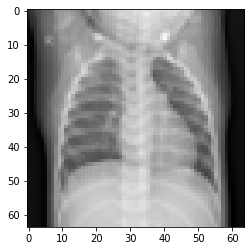

Pixel Size:  64 X 64
RGB Value at index [0,0]:  [80 80 80]


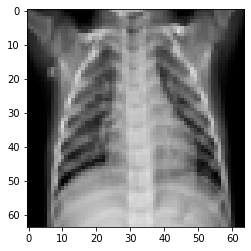

Pixel Size:  64 X 64
RGB Value at index [0,0]:  [0 0 0]


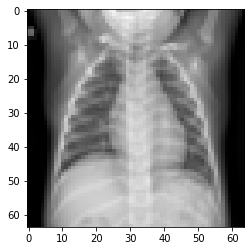

Pixel Size:  64 X 64
RGB Value at index [0,0]:  [24 24 24]


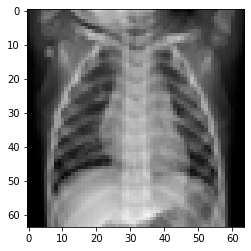

Pixel Size:  64 X 64
RGB Value at index [0,0]:  [19 19 19]


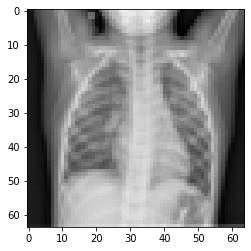

Pixel Size:  64 X 64
RGB Value at index [0,0]:  [30 30 30]


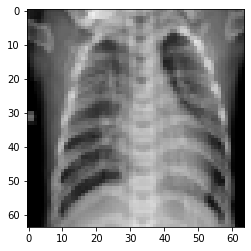

Pixel Size:  64 X 64
RGB Value at index [0,0]:  [36 36 36]


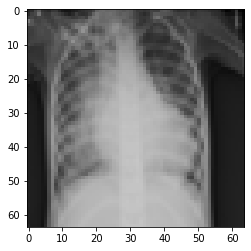

Pixel Size:  64 X 64
RGB Value at index [0,0]:  [0 0 0]


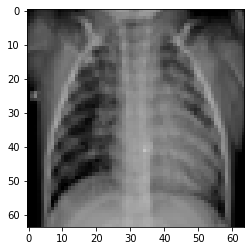

Pixel Size:  64 X 64
RGB Value at index [0,0]:  [76 76 76]


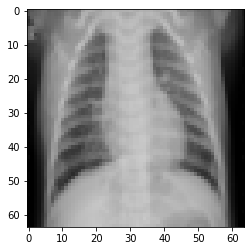

Pixel Size:  64 X 64
RGB Value at index [0,0]:  [24 24 24]


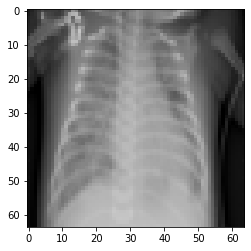

x_final:  (12288, 10)
y_final:  (1, 10)
Time elapsed:  1.3651628494262695  seconds


In [5]:
"""
Created a seperate, much smaller training_set to test pre-processing functions
"""

#TEST FILES (5 images per file)

pathOne = "chest_xray/trainTEMP/normal"
pathTwo = "chest_xray/trainTEMP/pneumonia"

time_lapse, [x_temp,y_temp] = time_elapsed(load_xy_set, pathOne, pathTwo)

#Verify contents and shapes match each other
#x_train.shape ==> (total_training_examples,width,height,RGB)
print("x_final: ",x_temp.shape)
#print("x_final[0]: ", x_temp[:,0])

#y_train.shape ==> (1,total_training_examples)
print("y_final: ",y_temp.shape)
#print("y_final[0]:", y_temp[:,0])
print("Time elapsed: ", time_lapse, " seconds")

## Activity Rule

Now, we move onto the activity rule. As previously demonstrated, the sigmoid, and tanh functions are popular examples of activation functions. However, we also introduce another example known as the ReLu function. The ReLu function is a linear function which has been known to perform [better than the sigmoid and tanh functions](https://www.datasciencecentral.com/profiles/blogs/deep-learning-advantages-of-relu-over-sigmoid-function-in-deep). I will use each activation function to represent the differences

In [7]:
"""
Helper activation functions: 
def sigmoid() #Binary classification; used in output layer
def relu() #Used in hidden layers
def tanh() #Used in hidden layers
""" 
def sigmoid(Z):
    #Treat Z as np.array
    #Use for last layer activation function
    s = 1/(1+np.exp(-Z))
    
    return s
   
    
def relu(Z):
    #Treat Z as np.array
    s = (abs(Z)+Z)/2
    return s

#tanh() function can be used with numpy:
#tanh() --> np.tanh()
    


## Plot Differences
Below is a plot of each activation function. The difference between the ReLu function and the Tanh/Sigmoid functions is that it is a piecewise, linear function. Again, ReLu tends to perform better than the other two activation functions. 

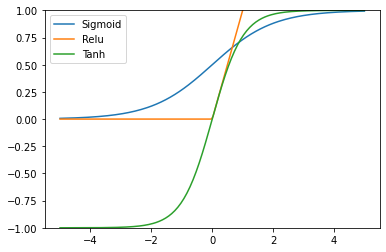

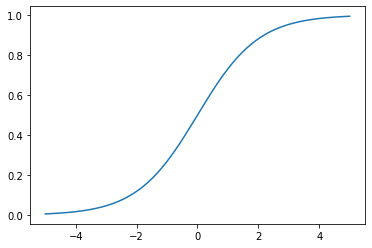

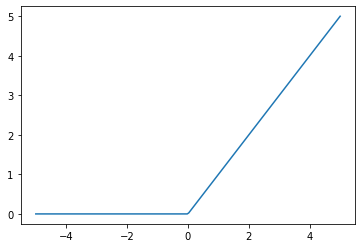

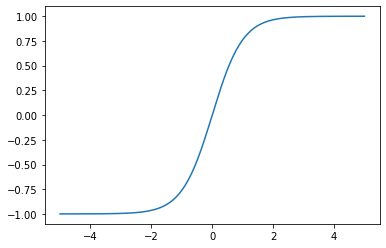

In [8]:
"""
Verify that relu & sigmoid & tanh work
"""
Z = np.linspace(-5, 5, 200)
#print(Z.shape)



plt.plot(Z, sigmoid(Z), label = "Sigmoid")
plt.plot(Z, relu(Z), label = "Relu")
plt.plot(Z, np.tanh(Z), label = "Tanh")

plt.ylim([-1,1])

plt.legend()
plt.show()

plt.plot(Z, sigmoid(Z), label = "Sigmoid")
plt.show()
plt.plot(Z, relu(Z), label = "Relu")
plt.show()
plt.plot(Z, np.tanh(Z), label = "Tanh")
plt.show()


#print("Sigmoid: \n",sigmoid(Z))
#print("Relu: \n",relu(Z))
#print("Tanh: \n",np.tanh(Z))

## Activity Rule

Now we discuss the "activation of the neuron" or the parameters modified for each neuron to "learn." We use a weight matrix to modify multiple neurons, but we also modify the original equation by adding a bias. The new formula for the activation of the neuron would go from $$a = \sum w_i x_i$$ to $$a_{i,j} = w_{i,j} x_{i,j} + b_{i,j},$$ for some $i$th layer and $j$th neuron in said layer. `initialize_parameters` constructs the weight and bias matrix to fit the structure of our neural network, depending on the dimensions we desire (denoted by layer_dims).

Now, we move onto the architecture of the NN, and visualize the NN that we use.


In [9]:
"""
initialize_weights & biases
Get the weights & biases for each individual layer & respective neurons/nodes in L-layer NN
"""

def initialize_parameters(layer_dims):
    parameters = {}
    L = len(layer_dims) #Number of layers in the network
    
    for l in range(1,L):
        #print all of the dimensions that weight & bias would have in layer l
        #print("Layer_dimensions: ",layer_dims[l], layer_dims[l-1])
        parameters['W'+str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*.01
        parameters['b'+str(l)] = np.random.randn(layer_dims[l],1)
        
        assert(parameters['W'+str(l)].shape == (layer_dims[l],layer_dims[l-1]))
        assert(parameters['b'+str(l)].shape == (layer_dims[l], 1))
        
        
    return parameters

## Architecture of the NN

The sample NN architecture below is a 4-layer NN architecture, with multiple weights and biases. Using a modified image loader, we can display the image. 

There are three input features $X_1, X_2, X_3$, three layers (input, hidden, output) $A^i$: $i = 1, 2, 3$, four nodes per input and hidden layer $A_j$: $j = 1, 2, 3, 4$ and a single node per output layer $y$.

Pixel Size:  410 X 820
RGB Value at index [0,0]:  [255 255 255]


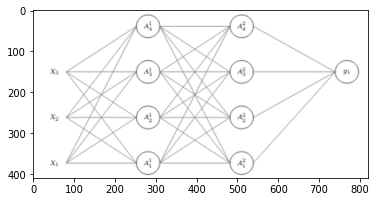

In [10]:
#New def to give better quality images
def load_images_show(folder):
    image_size = 410
    images = []
    counter =0
    for filename in os.scandir(folder):
            counter += 1
            
            #Consider edge-case where there is a folder inside the list of images
            if(os.path.isdir(filename)):
                continue
            
            #Path/to/file + /filename.extension
            img = Image.open(os.path.join(folder,os.path.basename(filename)))
        
            #standardize image size for easier computation
            img = img.resize((image_size*2, image_size))
            img = np.array(img.convert(mode = "RGB"))
                                    
            if(counter %100 == 0):
                print("Iteration: ", counter,": ",filename)
            
            images.append(img)
            
            #Print Image shape
            print("Pixel Size: ", img.shape[0],"X",img.shape[1])
            #Print Image RGB value at pixel[0,0]
            print("RGB Value at index [0,0]: ", img[0,0,:])
            plt.imshow(img)
            plt.show()
            
    return np.asarray(images)

#Load file here!
NN_architecture = load_images_show('images')


Below is a practical example and an implementation of `initialize_parameters`. We request $4$ layers as per the size of $len($layer_dims$) - 1$; in other words, we could insert an additional number and increase the layer count (creating a deep neural network). We could also increase the nodes per layer by increasing the number in each element of layer_dims (except element 0).

In [11]:
"""
Test the initialize_parameters function:
-Confirm that it produces the proper shapes for a given set of layer_dims

Pseudo-code:

for x in range(1,len(layer_dims)):
 weight.shape = (layer_dims[x], [x-1])
 bias.shape = (layer_dims[x], [x-1])
 
"""
layer_dims = [x_temp.shape[0],5, 4, 3, 1]
counter = 1
print("X_input: ", x_temp.shape[0])

time_lapse, parameters = time_elapsed(initialize_parameters,layer_dims)
print("Time elapsed:", time_lapse,"seconds")

#Test for proper bias & weight shapes
for x in parameters:
    print(x, ": ", parameters[x].shape)

X_input:  12288
Time elapsed: 0.0020902156829833984 seconds
W1 :  (5, 12288)
b1 :  (5, 1)
W2 :  (4, 5)
b2 :  (4, 1)
W3 :  (3, 4)
b3 :  (3, 1)
W4 :  (1, 3)
b4 :  (1, 1)


## Functions of Neural Network

Now that we have processed the images and created the architecture of our NN, we can begin constructing the four processes of a NN: forward-propagation, back-propagation, the cost function, and gradient descent. We'll start first with forward propagation: 

### Forward-Propagation

Using the formula described in the activity rule: $$a_{i,j} = w_{i,j} x_{i,j} + b_{i,j},$$ we can compute the activiation of a single neuron. However, we need to generalize this in order to create a proper neural network, which we will do so. Included in forward propagation is `linear_forward` and `activation_forward`, which is analogous to the activity rule of our discussion. `linear_forward` calculates the equation above to produce a new result for a single neuron, while `activation_forward` is a list of activation functions. 

In [12]:
"""
#forward propogation
def forward_propogate()
Calculate Z for a single layer

Final Z dimension should be (W[l-1].shape[0],1)
"""

def linear_forward(A, W, b):
    
    #Calculate Z in Neuron
    Z = np.dot(W, A) + b


    assert(Z.shape == (W.shape[0], A.shape[1]))
    
    #Save cache for backward propogation    
    cache = (A, W, b)
    
    return Z, cache






In [13]:
"""
#forward propogation
calculate the activation function portion of forward propogation

Use either (Relu and sigmoid) or (tanh and sigmoid) for best performance
"""


def activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A = relu(Z)
        
    elif activation == "tanh":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A = np.tanh(Z)
        
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, Z)
    return A, cache

#### Generalization

In the `forward_propagation` function, we generalize our neural network model for an arbitrary number of neurons and an arbitrary amount of layers. At the input and hidden layers, we repeatedly calculate `linear_forward` and `activation_forward` for every neuron. At the output layer, however, we use the sigmoid function to make our final binary classification prediction.

In [14]:
"""
#Forward propogation
put together the previous forward_propogation helper functions into a single model
"""

def forward_propogation(X, parameters, hidden_activation):
    caches = []
    A = X
    L = len(parameters)//2
       
    for l in range(1, L):
        A_prev = A
        A, cache = activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], hidden_activation)
        caches.append(cache)
    
    #Compute final prediction
    AL, cache = activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "sigmoid")
    caches.append(cache)
    assert(AL.shape == (1,X.shape[1]))
    
    return AL, caches

### Objective Function

Now that we have passed the activity rule portion, we can move onto the objective function, also known as the cost function, which is simply a measurement for the error of the neural network. The cost function formula we use is: $$J = (-1/m) * (\sum_{i}^m y^{i} log(PredictionX^{i}) + (1-y^i)log(1-PredictionX^i),$$

where $m$ is the number of images that we are receiving, $y$ is the label for image $i$, and $PredictionX$ is the prediction made by the neural network for image $i$. The reason we use this function is because we are accurately able to determine the how far our prediction is from the original label; in other words, does $PredictionX^i$ approach $y^i$? `compute_cost` implements this function.

In [15]:
"""
#Cost function
def compute_cost()

Implement loss function for binary classifcation:
-1/m sum(Ylog(A) + (1-Y)log(1-A))
"""

def compute_cost(A_final, Y):
    
    m = Y.shape[1]
    
    
    cost = -1/m * np.sum(Y*np.log(A_final) + (1-Y)*np.log(1-A_final))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost


### Back-Propagation

At this point, we have made our predictions with Forward propagation, and we have estimated the error for our problem. How do we minmize this error? 

We can try differentiation! If we can differentiate the weight, bias, and activation values, we can manipulate the slope repeatedly until the slope is 0 (elaborated upon in the gradient descent portion). The formulas for the activation, weight, and bias derivatives are given by:

$$
    dA_k = W^T * dA_{k+1},
$$
$$
    dW_k = (dA_{k+1} * A_{k}^T )/m,
$$
$$
    db_k = \sum dA_{k+1} /m,
$$

Where $k$ is the layer of the NN. Note that we need the derivative of the succeding layer, $A_{k+1}$ in order to calculate the derivatives, or the gradients, of $W_k$, $b_k$, and $A_k$. This means that we have to start at the last layer, and the derivative for this layer is $$dA_l = -(\frac{Y}{A_l} - \frac{1-Y}{1-A_l}),$$ for a label $Y$ and the layer output $A_l$. (I'm not sure how this was derived) `linear_backward` calculates the gradients for every input/hidden layer, and `activation_backwards` calculates the same gradients for the output layer, $A_l$. Now, we have to generalize this to every neuron and every layer of neurons.

In [16]:
"""
#Backward propogation
def  linear_backward()
calculate gradients (derivatives) of a layer,i, 
"""

def linear_backward(dZ, cache):
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    
    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis = 1, keepdims = True)/m
    dA_prev = np.dot(W.T,dZ)
    
    
    assert(dA_prev.shape == A_prev.shape)
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    
    return dA_prev, dW, db



In [17]:
"""
#Backward propogation
activation_backward(dA, cache, activation):
Calculate derivatives of activation function & Z for a given layer, i
"""

def activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache #(A, W, b) & (Z)
    
    
    if activation == "relu":# Might be incorrect
        Z = activation_cache
        dZ = np.array(dA, copy = True)
        dZ[Z<=0] = 0
        
        assert(dZ.shape == Z.shape)
        
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        s = sigmoid(activation_cache)
        dZ = dA* s*(1-s)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "tanh":
        dZ = dA*(1-(np.tanh(activation_cache)**2))
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    
    return dA_prev, dW, db
    

#### Generalization

Now, we can apply this to our general neural network model. `backward_propogation` calculates every single gradient inside the neural network. First, it calls `activation_backward`, which then calls `linear_backward` to compute the respective gradients. Because at the output layer, we use the sigmoid function, we have to perform a derivative with respect to the sigmoid function for the output layer gradient.

In [18]:
"""
#Backward propogation
combine activation & linear backwardpropogation gradients across all layers
"""

def backward_propogation(AL, Y, caches, hidden_activation):
    grads = {}
    L = len(caches) #Number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    #Derivative of loss function in compute_cost()
    dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL))
    
    #Compute sigmoid derivative
    current_cache = caches[L-1]
    grads["dA"+str(L-1)], grads["dW"+str(L)],grads["db"+str(L)] = activation_backward(dAL, current_cache, "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA"+str(l+1)],current_cache, hidden_activation)
        grads["dA"+str(l)] = dA_prev_temp
        grads["dW"+str(l+1)] = dW_temp
        grads["db"+str(l+1)] = db_temp
        
    return grads

#### Gradient Descent

Gradient descent is the process of updating the parameters and minimizing the objective function. In other words, we repeatedly use the gradients calculated in back-propagation to help the weights and biases reach an optimal value. `update_parameters` implements this function by subtracting the gradients (multiplied with an arbitrary learning rate, $\alpha$) from its respective parameters

In [19]:

"""
#Gradient Descent
def update_parameters()

modify the weights & biases based on backward_propogation
"""

def update_parameters(parameters ,grads, learning_rate):
    
    L = len(parameters)//2
    
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate *grads["dW"+str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate*grads["db"+str(l+1)]
    return parameters
        
        

## The completed model

Now that we have completed each process of the neural network mode, constructed the architecture, and processed our images, we can generalize our NN model and begin our application

In [27]:
"""
#Neural Network 

Combine all helper functions (forward_propogation, backward_propogation, compute_cost, update_parameters)
To create an L-layer Neural Network
"""

def L_layer_model(X, Y, layer_dims, hidden_activation, learning_rate, num_iterations, print_cost = False):
    costs = [] # Keep track of cost to plot later
    
    time_architecture,parameters = time_elapsed(initialize_parameters,layer_dims)
    
    #Measure the time it takes to implement each process
    time_forward = 0
    time_backward = 0
    time_cost = 0
    time_update = 0
    #Sum of every process over num_iterations
    time_gradient_descent = 0
    for i in range(0, num_iterations):
        #Forward prop
        time_f, [AL,caches] = time_elapsed(forward_propogation,X,parameters, hidden_activation)
        time_forward += time_f

        #Cost function
        time_c, cost = time_elapsed(compute_cost,AL,Y)
        time_cost += time_c
        
        #Backward prop
        time_b,grads = time_elapsed(backward_propogation,AL,Y,caches, hidden_activation)
        time_backward += time_b

        time_u,parameters = time_elapsed(update_parameters,parameters,grads,learning_rate)
        time_update += time_u
        
        if print_cost and i%100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            costs.append(cost)
            
    time_gradient_descent = time_forward + time_backward+time_cost + time_update
    time_list = {'f':time_forward, 
                 'b':time_backward, 
                 'c':time_cost,
                 'u':time_update,
                 'g':time_gradient_descent
                 'a':time_architecture
                }
    
    
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations(per hundreds)')
    plt.title("Learning rate = "+str(learning_rate))
    plt.show()
    
    
    return parameters, time_list


In [21]:
"""
Grab the actual training set (4,500+ examples) 
"""
pathOne = "chest_xray/train/NORMAL"
pathTwo = "chest_xray/train/PNEUMONIA"

x_train, y_train = load_xy_set(pathOne,pathTwo)

Iteration:  100 :  <DirEntry 'NORMAL2-IM-0893-0001.jpeg'>
Iteration:  200 :  <DirEntry 'NORMAL2-IM-0633-0001.jpeg'>
Iteration:  300 :  <DirEntry 'IM-0205-0001.jpeg'>
Iteration:  400 :  <DirEntry 'NORMAL2-IM-0621-0001.jpeg'>
Iteration:  500 :  <DirEntry 'IM-0590-0001.jpeg'>
Iteration:  600 :  <DirEntry 'IM-0177-0001.jpeg'>
Iteration:  700 :  <DirEntry 'IM-0348-0001.jpeg'>
Iteration:  800 :  <DirEntry 'NORMAL2-IM-0508-0001.jpeg'>
Iteration:  900 :  <DirEntry 'NORMAL2-IM-0458-0001.jpeg'>
Iteration:  1000 :  <DirEntry 'NORMAL2-IM-0908-0001.jpeg'>
Iteration:  1100 :  <DirEntry 'NORMAL2-IM-0582-0001.jpeg'>
Iteration:  1200 :  <DirEntry 'IM-0517-0001.jpeg'>
Iteration:  1300 :  <DirEntry 'IM-0279-0001.jpeg'>
Iteration:  100 :  <DirEntry 'person531_bacteria_2235.jpeg'>
Iteration:  200 :  <DirEntry 'person1141_virus_1890.jpeg'>
Iteration:  300 :  <DirEntry 'person1433_bacteria_3701.jpeg'>
Iteration:  400 :  <DirEntry 'person74_bacteria_362.jpeg'>
Iteration:  500 :  <DirEntry 'person445_virus_912

In [22]:
#Confirm shape of the traning examples
x_train.shape


(12288, 5216)

How many Neural Networks are we training:  6
List of Learning Rates:  [0.099, 0.016, 0.099, 0.016, 0.099, 0.016]
List of Layers dimensions [[12288, 25, 1], [12288, 35, 1], [12288, 35, 1], [12288, 25, 1], [12288, 30, 1], [12288, 30, 1]]
Time to initialize architecture: 0.010269880294799805 seconds
Cost after iteration 0: 0.7192882996587006
Cost after iteration 100: 0.527143530863651
Cost after iteration 200: 0.6205155929740988
Cost after iteration 300: 0.3136859657115537
Cost after iteration 400: 0.29489069543423313
Cost after iteration 500: 0.26144008411556874
Cost after iteration 600: 0.23279153058892654
Cost after iteration 700: 0.22259708596347427
Cost after iteration 800: 0.15031962655848125
Cost after iteration 900: 0.14253359979418753


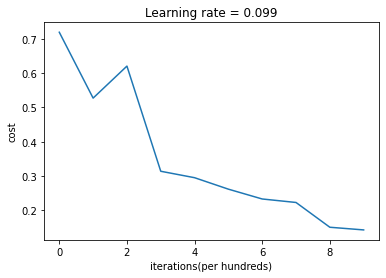

Time lapse for architecture:
Forward Propagation: 122.28902244567871
Backward Propagation: 556.5164308547974
Updating Gradients: 1.5083322525024414
Calculating Cost: 0.5726261138916016
Overall feedforward Neural Network using Gradient Descent: 680.8864116668701
Time to initialize architecture: 0.01734614372253418 seconds
Cost after iteration 0: 0.7498767613803985
Cost after iteration 100: 0.4057562489219181
Cost after iteration 200: 0.34858364903130273
Cost after iteration 300: 0.264578423691394
Cost after iteration 400: 0.21999542705176367
Cost after iteration 500: 0.18866127960917767
Cost after iteration 600: 0.16143632735538715
Cost after iteration 700: 0.13271857008476434
Cost after iteration 800: 0.12807867153760524
Cost after iteration 900: 0.12128873952587184


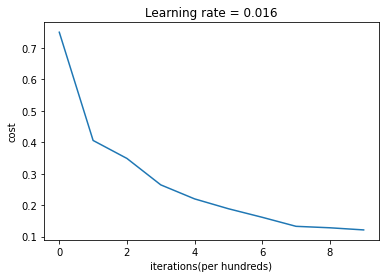

Time lapse for architecture:
Forward Propagation: 145.6029691696167
Backward Propagation: 583.9483807086945
Updating Gradients: 2.065067768096924
Calculating Cost: 0.5938749313354492
Overall feedforward Neural Network using Gradient Descent: 732.2102925777435
Time to initialize architecture: 0.017276287078857422 seconds
Cost after iteration 0: 0.5847762555999846
Cost after iteration 100: 0.5647403375036973
Cost after iteration 200: 0.5708910997933627
Cost after iteration 300: 0.4537459902764534
Cost after iteration 400: 0.45724350832760946
Cost after iteration 500: 0.28565583205787304
Cost after iteration 600: 0.2984242819563269
Cost after iteration 700: 0.2615334420137614
Cost after iteration 800: 0.2320743775145657
Cost after iteration 900: 0.2113487214770982


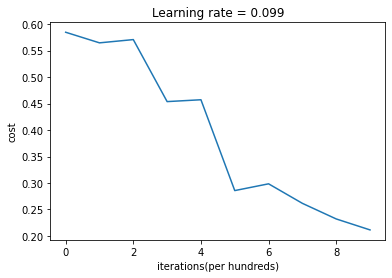

Time lapse for architecture:
Forward Propagation: 133.6894462108612
Backward Propagation: 561.4777097702026
Updating Gradients: 1.9780058860778809
Calculating Cost: 0.5796794891357422
Overall feedforward Neural Network using Gradient Descent: 697.7248413562775
Time to initialize architecture: 0.01229405403137207 seconds
Cost after iteration 0: 0.8924288668514622
Cost after iteration 100: 0.3870190100413582
Cost after iteration 200: 0.32023730407565787
Cost after iteration 300: 0.2587474617376235
Cost after iteration 400: 0.21439099450372556
Cost after iteration 500: 0.18632558689307985
Cost after iteration 600: 0.18998380855486327
Cost after iteration 700: 0.20217011874495494
Cost after iteration 800: 0.12563409161808883
Cost after iteration 900: 0.12512549885399124


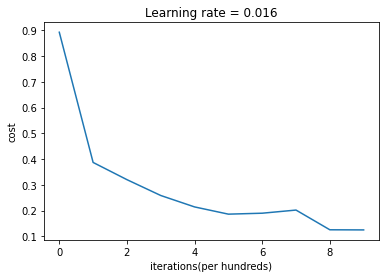

Time lapse for architecture:
Forward Propagation: 135.64504265785217
Backward Propagation: 554.3152847290039
Updating Gradients: 1.513298749923706
Calculating Cost: 0.5798711776733398
Overall feedforward Neural Network using Gradient Descent: 692.0534973144531
Time to initialize architecture: 0.014996767044067383 seconds
Cost after iteration 0: 0.5826773079559171
Cost after iteration 100: 0.5748470717424707
Cost after iteration 200: 0.5730000467581241
Cost after iteration 300: 0.5674715804732479
Cost after iteration 400: 0.4669008078099325
Cost after iteration 500: 0.33463667837525896
Cost after iteration 600: 0.28611831807993404
Cost after iteration 700: 0.2541806876439174
Cost after iteration 800: 0.22922496806265058
Cost after iteration 900: 0.20803658653376714


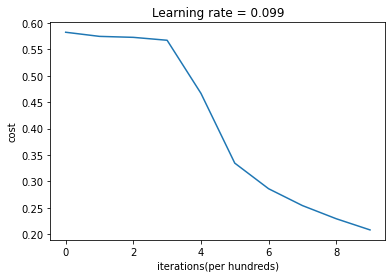

Time lapse for architecture:
Forward Propagation: 139.29986953735352
Backward Propagation: 565.9700446128845
Updating Gradients: 1.7756092548370361
Calculating Cost: 0.5664710998535156
Overall feedforward Neural Network using Gradient Descent: 707.6119945049286
Time to initialize architecture: 0.014766693115234375 seconds
Cost after iteration 0: 0.5986191217806403
Cost after iteration 100: 0.49231172847714727
Cost after iteration 200: 0.37783943320802305
Cost after iteration 300: 0.27571999829542226
Cost after iteration 400: 0.22213380692535994
Cost after iteration 500: 0.19053491411532725
Cost after iteration 600: 0.16744096980569204
Cost after iteration 700: 0.140598400838977
Cost after iteration 800: 0.12620129810807051
Cost after iteration 900: 0.12031702638119195


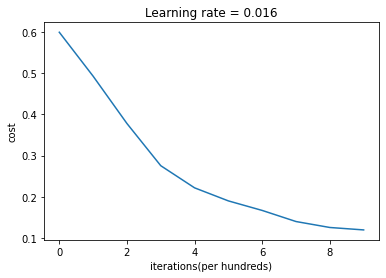

Time lapse for architecture:
Forward Propagation: 141.21795392036438
Backward Propagation: 569.3114080429077
Updating Gradients: 1.785938024520874
Calculating Cost: 0.5849871635437012
Overall feedforward Neural Network using Gradient Descent: 712.9002871513367


In [28]:
"""
Train a random set of Neural Networks to see best performance

'relu' can be replaced with 'tanh' or 'sigmoid', though it is not recommended to use sigmoid

I Used a nested for loop to consider different layer_sizes, different neural network sizes 
(the number of layers in a NN), and different learning_rates.  

Best performing hyperparameters:
Iterations = 1000
Single-layer Neural Network
Hidden layer size = 35 or 25 or 30
hyperparemeter = .099 or .016

Best Accuracy on Test set: 
Best Accuracy on Validation set: 94%
Best Accuracy on Train set: 95%
"""

#Constant parameters
input_size = x_train.shape[0]
output_size = 1
hidden_activation = "relu"
iterations = 1000

#Creating of list of hyperparameters to try
#Best performing set of hyperparameters
list_of_h_layers = [25, 35, 35, 25, 30, 30]
learning_rate_list = [.099, .016, .099,.016, .099,.016] #Best learning rates received so far
layer_list = []


parameters = [] #Stores the trained parameters

#Commented out nested for loop after determining 
#the best hyperparameters
for x in range (6):#Number Of test cases
    layer_dims = [input_size]
    layer_dims.append(list_of_h_layers[x])
#    for y in range(1): #Number of hidden layers in test case x
#        hidden_layer_size.append(randint(10,40))
#        layer_dims.append(hidden_layer_size[y])
    
    layer_dims.append(output_size)
    #list_of_h_layers.append(hidden_layer_size)#add to the list
    layer_list.append(layer_dims)
#    learning_rate_list.append(randint(1,100)/1000)#Find the best learning rate

print("How many Neural Networks are we training: ", len(learning_rate_list))
print("List of Learning Rates: ", learning_rate_list)
print("List of Layers dimensions", layer_list)


#Test Neural Networks with differing hyperparameters
for x in range(len(layer_list)):
    parameter, time_list = L_layer_model(x_train, y_train, layer_list[x],hidden_activation, learning_rate_list[x],iterations, True)
    parameters.append(parameter)
    print("Time lapse for architecture:",time_list["a"])
    print("Forward Propagation:", time_list["f"])
    print("Backward Propagation:", time_list["b"])
    print("Updating Gradients:", time_list["u"])
    print("Calculating Cost:", time_list["c"])
    print("Overall feedforward Neural Network using Gradient Descent:", time_list["g"])
    

# Epilogue

We have now finished training 6 unique neural network architectures. At this point, we can grab the results from a simple forward_propagation call to understand how accurate our model is! `predict` makes our prediction.

In [29]:
#Function to predict with TRAINED NEURAL NETWORKS
def predict(X, Y, parameters, hidden_activation):
    m = X.shape[1]
    n = len(parameters) //2 #Number of layers in the neural network
    
    results, caches = forward_propogation(X, parameters, hidden_activation)
    results = results//(0.5) #Floor divide .5 & receive 1's & 0's
    
    
    accuracy = np.sum((results==Y)/m)
    
    
   # print("Accuracy: " + str(accuracy))
    
    return results, accuracy
    

## Testing success rate on training set
Since we created numerous neural network models, we're going to making a list of prediction and accuracy rates to determine how accurate each model is. We start by testing with the training set, which should yield high accuracy results

In [30]:

#Check predictions on the training set -- Should be very accurate(95%+)
p_train_list = []
accuracy_train_list = []
for x in parameters:
    p_train, accuracy_train = predict(x_train,y_train,x, hidden_activation)
    
    p_train_list.append(p_train)
    accuracy_train_list.append(accuracy_train)
    
#Print accuracy of Neural Networks on train set
i = 0
for accuracy in accuracy_train_list:
    i += 1
    guess = "Architecture " + str(i) + " is: " + str(accuracy*100) + "% accurate on train set"
    print(guess)

Architecture 1 is: 86.56058282208589% accurate on train set
Architecture 2 is: 95.59049079754601% accurate on train set
Architecture 3 is: 92.31211656441718% accurate on train set
Architecture 4 is: 95.59049079754601% accurate on train set
Architecture 5 is: 93.78834355828221% accurate on train set
Architecture 6 is: 95.47546012269939% accurate on train set


## Testing success rate on 'validation set'

A validation set is a small set of examples which we had not trained the neural network on. While we may have accustomed the neural networks to train well on the training set, we have to make sure the neural network can account for real-world examples (otherwise, the model is useless). The validation set is a quick way of 'validating' our work.

In [31]:
#Load validation set to test trained Neural Networks
pathOne = "chest_xray/val/NORMAL"
pathTwo = "chest_xray/val/PNEUMONIA"

x_val, y_val = load_xy_set(pathOne,pathTwo)

In [32]:
#Test Neural Networks on validation set
p_val_list = []
accuracy_val_list = []
hidden_activation = hidden_activation
for x in parameters:
    p_val, accuracy_val = predict(x_val, y_val, x, hidden_activation)
    
    p_val_list.append(p_val)
    accuracy_val_list.append(accuracy_val)

#Print accuracy of Neural Networks on validation set
i = 0
for accuracy in accuracy_val_list:
    i += 1
    guess = "Architecture " + str(i) + " is: " + str(accuracy*100) + "% accurate on validation set"
    print(guess)

Architecture 1 is: 56.25% accurate on validation set
Architecture 2 is: 93.75% accurate on validation set
Architecture 3 is: 68.75% accurate on validation set
Architecture 4 is: 93.75% accurate on validation set
Architecture 5 is: 75.0% accurate on validation set
Architecture 6 is: 93.75% accurate on validation set


## Testing success rate on test set

Finally, we have the test set, which is an extremely large set of data that we use to verify that our neural network model is doing a good job of estimating! It operates similarly to the validation set, but is much larger.

In [33]:
#Print accuracy of Neural Networks on test set
pathOne = "chest_xray/test/NORMAL"
pathTwo = "chest_xray/test/PNEUMONIA"

x_test, y_test = load_xy_set(pathOne, pathTwo)


Iteration:  100 :  <DirEntry 'IM-0081-0001.jpeg'>
Iteration:  200 :  <DirEntry 'NORMAL2-IM-0221-0001.jpeg'>
Iteration:  100 :  <DirEntry 'person113_bacteria_543.jpeg'>
Iteration:  200 :  <DirEntry 'person141_bacteria_681.jpeg'>
Iteration:  300 :  <DirEntry 'person33_virus_72.jpeg'>


In [34]:
p_test_list = []
accuracy_test_list = []

for x in parameters:
        p_test, accuracy_test = predict(x_test, y_test, x, hidden_activation)
        
        p_test_list.append(p_test)
        
        accuracy_test_list.append(accuracy_test)
        
#Print accuracy of Neural Networks on test set
i = 0
for accuracy in accuracy_test_list:
    i += 1
    guess = "Architecture " + str(i) + " is: " + str(accuracy*100) + "% accurate on test set"
    print(guess)

Architecture 1 is: 66.18589743589742% accurate on test set
Architecture 2 is: 75.80128205128204% accurate on test set
Architecture 3 is: 70.51282051282051% accurate on test set
Architecture 4 is: 75.16025641025641% accurate on test set
Architecture 5 is: 71.63461538461537% accurate on test set
Architecture 6 is: 75.0% accurate on test set


# "Sandbox" mode

At this point, the neural networks have been completely trained. We can test each architecture's prediction by changing the parameter `test_index`. 

Number of images available to test on:  624
Architecture 1 guessed: Pneumonia
Architecture 2 guessed: Safe Lung
Architecture 3 guessed: Pneumonia
Architecture 4 guessed: Pneumonia
Architecture 5 guessed: Pneumonia
Architecture 6 guessed: Pneumonia
Actual label: Safe
Shape of the image:  (12288,)


[]

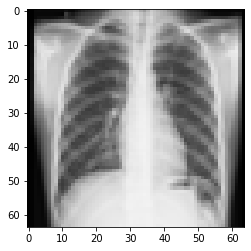

In [35]:
print("Number of images available to test on: ",y_test.shape[1])



prediction_list = [] 

test_index = 100 #Change this number for different images from the TEST SAMPLE

sample_prediction = x_test[:,test_index].reshape((x_test[:,test_index].shape[0], 1))
sample_label = y_test[:,test_index].reshape(y_test[:,test_index].shape[0],1)


"""Make predictions:"""
for architecture in parameters:
    p_test, accuracy_test = predict(sample_prediction, y_test, architecture, hidden_activation)
    prediction_list.append(p_test)
    
"""Format Results of prediction:"""
#Guess
i = 0
for prediction in prediction_list:
    i += 1
    guess = "Architecture " + str(i) + " guessed: "
    if(prediction[0][0] == 1):
        guess += "Pneumonia"
    else:
        guess += "Safe Lung"
    print(guess)

#Actual Result
label = "Actual label: "
if(sample_label[0][0] == 1):
    label += "Pneumonia"
else:
    label += "Safe"
print(label)


"""Image details"""
print("Shape of the image: ", x_test[:,0].shape)
plt.imshow(x_test[:,0].reshape((64, 64, 3))) #MUST CHANGE DIMENSIONS IF YOU CHANGE IMAGE RESOLUTION
plt.plot()

## Results Conclusion

We were able to attain over 75% accuracy on the test set. The average accuracy was decently high too, especially for neural network models without optimization parameters such as [regularization](https://towardsdatascience.com/how-to-improve-a-neural-network-with-regularization-8a18ecda9fe3). The cost of training these images is incredibly high; The following is a table of the computation time per neural network (NN) architecture


|Phase |NN 6 | NN 5 | NN 4 | NN 3 | NN 2| NN 1|
|------|---------------|----------------|----------------|----------------|----------------|---------------|
|Building NN (Seconds)|$0.01476669$|$0.01499676$|$0.0122940$|$0.01727628$|$0.0173461$|$0.01026988$|
|Forward-Prop. (Seconds)|$141.2179$|$139.2998$|$135.6450$|$133.689$|$145.602$|$122.2890$|
|Back-Prop. (Seconds)|$569.311$|$565.970$|$554.315$|$561.477$|$583.948$|$556.516$|
|Gradient Update (Seconds)|$1.78593$|$1.775609$|$1.51329$|$1.978005$|$2.06506$|$1.508332$|
|Cost Measurement (Seconds)|$0.584987$|$0.566471$|$0.579871$|$0.579679$|$0.593874$|$0.572626$|
|NN w/ gradient descent (Seconds)|$712.900$|$707.611$|$692.053$|$697.724$|$732.210$|$680.886$|

Where `NN w/ gradient descent` is equal to the sum of forward propagation, back-propagation, gradient update, and cost measurement.